
# compare T-S-diagram of synthetic floats to real-world floats
# Fig. 4 in GMD paper


In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import seawater
#from seawater import dist
#import seawater as sw
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import random
from numba import njit
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from mpasview import * # Qing's library, modified by Yohei Takano, Dec, 2022
from argopy import DataFetcher as ArgoDataFetcher
from scipy.interpolate import interp1d


In [2]:
#-----
# saving plots
#-----

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    

In [3]:
####
# mesh info etc.
####

rad_to_deg = 180.0/np.pi
latlim = -45.0

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon  = meshfile['lonCell'].values*rad_to_deg
lat  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()


236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)


In [4]:
#----
# load daily float output from E3SM: latitude, temperature, salinity, DIC
#----
# NOTE: the reduction to "deep" floats is not 100% exact.
#  -> when running this over different years, a different number of floats is identified as "shallow" floats
#  -> for now, I kick out those that are "shallow" on day 1 of year 1
# How to treat this later?

path = '/global/cfs/cdirs/m4003/maltrud/6year/floats/'
year_list = ['0059']# '0055','0056','0057','0058','0059','0060']

# kick out floats in shallow regions (these are not advected I think)
ind = np.where(zlevs<=2200)[0]

for yy in range(0,len(year_list)):
    print('Load year '+year_list[yy])
    file1 = 'floats.year'+year_list[yy]+'.nc'   
    data = xr. open_dataset(path+file1)

    lon_1   = data['particleColumnLon'].values*rad_to_deg 
    lat_1   = data['particleColumnLat'].values*rad_to_deg
    
    temp_1  = data['particleColumnTemperature'].values
    salt_1  = data['particleColumnSalinity'].values
    no3_1   = data['particleColumnNO3'].values #[:,0,:]
    
    # set missing values to NaN (deep ocean layers) 
    lat_1[no3_1==-1]=np.nan
    lon_1[no3_1==-1]=np.nan
    temp_1[no3_1==-1]=np.nan
    salt_1[no3_1==-1]=np.nan
    no3_1[no3_1==-1]=np.nan
    
    lat_1[no3_1==0]=np.nan
    lon_1[no3_1==0]=np.nan
    temp_1[no3_1==0]=np.nan
    salt_1[no3_1==0]=np.nan
    no3_1[no3_1==0]=np.nan
    
    print('Reduce to floats in the deep ocean')
    if yy==0: # only load the first time, re-use ind_deep
        aux = np.sum(np.isnan(no3_1[0,ind,:]),axis=0) # check if any of the depth levels shallower than 1100m is NaN
        ind_deep = np.where(aux==0)[0] # if it is, aux is >0; only keep those that are 0
  #  #print('Floats in the deep ocean:',ind_deep.shape)
    lon_1   = lon_1[:,:,ind_deep]
    lat_1   = lat_1[:,:,ind_deep]
    temp_1  = temp_1[:,:,ind_deep]
    salt_1  = salt_1[:,:,ind_deep]
    no3_1   = no3_1[:,:,ind_deep]
    
    # 10-daily only
    lon_1  = lon_1[0::10,:,:]
    lat_1  = lat_1[0::10,:,:]
    temp_1 = temp_1[0::10,:,:]
    salt_1 = salt_1[0::10,:,:]
    no3_1  = no3_1[0::10,:,:]
    
    #del lon_1,lat_1
    
print ('done')


# What to compare?

# time-averaged float data, year 1 only (I don't care so much about temporal evolution, and floats do not move that far)
# assess whether initial float distribution is enough to capture 


Load year 0059
Reduce to floats in the deep ocean
done


In [5]:
#---
# time average
#---

#lon_2  = np.mean(lon_1,axis=0)
#lat_2  = np.mean(lat_1,axis=0)
#temp_2 = np.mean(temp_1,axis=0)
#salt_2 = np.mean(salt_1,axis=0)
#no3_2  = np.mean(no3_1,axis=0)

lon_2  = np.copy(lon_1)
lat_2  = np.copy(lat_1)
temp_2 = np.copy(temp_1)
salt_2 = np.copy(salt_1)
no3_2  = np.copy(no3_1)

print(temp_2.shape)



(37, 60, 8943)


In [6]:
#----
# load Eulerian output
#----

path_full = '/global/cfs/cdirs/m4003/maltrud/6year/monthlyEulerianAverages/'

# Load data from input file (model output)
varname1 = 'timeMonthly_avg_activeTracers_temperature'
varname2 = 'timeMonthly_avg_activeTracers_salinity'
varname3 = 'timeMonthly_avg_ecosysTracers_NO3'

#temp = np.zeros(area.shape[0])
for yy in range(0,1):#len(year_list)):
    print('Load year '+year_list[yy])
    inputfile_run1 = path_full+'monthlyAverageEulerianFields.year'+year_list[yy]+'.nc'
    finput_run1 = xr.open_dataset(inputfile_run1)

    # MPAS-O mesh for EC30to60E2r2 run 1
    aux1 = finput_run1[varname1].data 
    temp = np.squeeze(aux1)[:,:,:]#.mean(axis=0) # annual mean
    del aux1
    aux1 = finput_run1[varname2].data
    salt = np.squeeze(aux1)[:,:,:]#.mean(axis=0) # annual mean
    del aux1
    aux1 = finput_run1[varname3].data
    no3  = np.squeeze(aux1)[:,:,:]#.mean(axis=0) # annual mean
    del aux1

temp = np.ma.masked_where(temp<-999,temp)
salt = np.ma.masked_where(salt<-999,salt)
no3  = np.ma.masked_where(no3<-999,no3)
print(no3.shape)

print('done')


Load year 0059
(12, 236853, 60)
done


In [7]:
#----
# mask shallow regions in Eulerian output 
#----
# these regions are not included in float output either!!!

#temp = np.ma.masked_where(topo<2000,temp)
#salt = np.ma.masked_where(salt<2000,temp)
#no3  = np.ma.masked_where(no3<2000,temp)

topo2 = np.tile(topo,[12,60,1])
topo2 = np.transpose(topo2,[0,2,1])

temp[topo2<2000] = np.nan
salt[topo2<2000] = np.nan
no3[topo2<2000] = np.nan

print('done')



done


In [8]:
#---
# seawater functions
#---
load_functions_explicitly = True

if load_functions_explicitly:

    def dens(s, t, p):
        """
        Density of Sea Water using UNESCO 1983 (EOS 80) polynomial.

        Parameters
        ----------
        s(p) : array_like
               salinity [psu (PSS-78)]
        t(p) : array_like
               temperature [℃ (ITS-90)]
        p : array_like
            pressure [db].

        Returns
        -------
        dens : array_like
               density  [kg m :sup:`3`]

        Examples
        --------
        >>> # Data from Unesco Tech. Paper in Marine Sci. No. 44, p22.
        >>> import seawater as sw
        >>> from seawater.library import T90conv
        >>> s = [0, 0, 0, 0, 35, 35, 35, 35]
        >>> t = T90conv([0, 0, 30, 30, 0, 0, 30, 30])
        >>> p = [0, 10000, 0, 10000, 0, 10000, 0, 10000]
        >>> sw.dens(s, t, p)
        array([  999.842594  ,  1045.33710972,   995.65113374,  1036.03148891,
                1028.10633141,  1070.95838408,  1021.72863949,  1060.55058771])

        References
        ----------
        .. [1] Fofonoff, P. and Millard, R.C. Jr UNESCO 1983. Algorithms for
           computation of fundamental properties of seawater. UNESCO Tech. Pap. in
           Mar. Sci., No. 44, 53 pp.  Eqn.(31) p.39.
           http://unesdoc.unesco.org/images/0005/000598/059832eb.pdf

        .. [2] Millero, F.J., Chen, C.T., Bradshaw, A., and Schleicher, K. A new
           high pressure equation of state for seawater. Deap-Sea Research., 1980,
           Vol27A, pp255-264. doi:10.1016/0198-0149(80)90016-3

        """

        s, t, p = list(map(np.asanyarray, (s, t, p)))

        # UNESCO 1983. Eqn..7  p.15.
        densP0 = dens0(s, t)
        K = seck(s, t, p)
        p = p / 10.  # Convert from db to atm pressure units.
        return densP0 / (1 - p / K)

    def dens0(s, t):
        """
        Density of Sea Water at atmospheric pressure.

        Parameters
        ----------
        s(p=0) : array_like
                 salinity [psu (PSS-78)]
        t(p=0) : array_like
                 temperature [℃ (ITS-90)]

        Returns
        -------
        dens0(s, t) : array_like
                      density  [kg m :sup:`3`] of salt water with properties
                      (s, t, p=0) 0 db gauge pressure

        Examples
        --------
        >>> # Data from UNESCO Tech. Paper in Marine Sci. No. 44, p22
        >>> import seawater as sw
        >>> from seawater.library import T90conv
        >>> s = [0, 0, 0, 0, 35, 35, 35, 35]
        >>> t = T90conv([0, 0, 30, 30, 0, 0, 30, 30])
        >>> sw.dens0(s, t)
        array([  999.842594  ,   999.842594  ,   995.65113374,   995.65113374,
                1028.10633141,  1028.10633141,  1021.72863949,  1021.72863949])

        References
        ----------
        .. [1] Fofonoff, P. and Millard, R.C. Jr UNESCO 1983. Algorithms for
           computation of fundamental properties of seawater. UNESCO Tech. Pap. in
           Mar. Sci., No. 44, 53 pp.  Eqn.(31) p.39.
           http://unesdoc.unesco.org/images/0005/000598/059832eb.pdf

        .. [2] Millero, F.J. and  Poisson, A. International one-atmosphere
           equation of state of seawater. Deep-Sea Res. 1981. Vol28A(6) pp625-629.
           doi:10.1016/0198-0149(81)90122-9

        """

        s, t = list(map(np.asanyarray, (s, t)))

        T68 = T68conv(t)

        # UNESCO 1983 Eqn.(13) p17.
        b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
        c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
        d = 4.8314e-4
        return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
                T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
                s ** 0.5 + d * s ** 2)

    def T68conv(T90):
        """
        Convert ITS-90 temperature to IPTS-68

        :math:`T68  = T90 * 1.00024`

        Parameters
        ----------
        t : array_like
               temperature [℃ (ITS-90)]

        Returns
        -------
        t : array_like
               temperature [℃ (IPTS-68)]

        Notes
        -----
        The International Practical Temperature Scale of 1968 (IPTS-68) need to be
        correct to the ITS-90. This linear transformation is accurate within
        0.5 ℃ for conversion between IPTS-68 and ITS-90 over the
        oceanographic temperature range.

        Examples
        --------
        >>> import seawater as sw
        >>> T68conv(19.995201151723585)
        20.0

        References
        ----------
        .. [1] Saunders, P. M., 1991: The International Temperature Scale of 1990,
           ITS-90. WOCE Newsletter, No. 10, WOCE International Project Office,
           Southampton, United Kingdom, 10.

        """
        T90 = np.asanyarray(T90)
        return T90 * 1.00024

    def smow(t):
        """
        Density of Standard Mean Ocean Water (Pure Water) using EOS 1980.

        Parameters
        ----------
        t : array_like
            temperature [℃ (ITS-90)]

        Returns
        -------
        dens(t) : array_like
                  density  [kg m :sup:`3`]

        Examples
        --------
        >>> # Data from UNESCO Tech. Paper in Marine Sci. No. 44, p22.
        >>> import seawater as sw
        >>> t = T90conv([0, 0, 30, 30, 0, 0, 30, 30])
        >>> sw.smow(t)
        array([ 999.842594  ,  999.842594  ,  995.65113374,  995.65113374,
                999.842594  ,  999.842594  ,  995.65113374,  995.65113374])

        References
        ----------
        .. [1] Fofonoff, P. and Millard, R.C. Jr UNESCO 1983. Algorithms for
           computation of fundamental properties of seawater. UNESCO Tech. Pap. in
           Mar. Sci., No. 44, 53 pp.  Eqn.(31) p.39.
           http://unesdoc.unesco.org/images/0005/000598/059832eb.pdf

        .. [2] Millero, F.J. and  Poisson, A. International one-atmosphere equation
           of state of seawater. Deep-Sea Res. 1981. Vol28A(6) pp625-629.
           doi:10.1016/0198-0149(81)90122-9

        """
        t = np.asanyarray(t)

        a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
             6.536332e-9)

        T68 = T68conv(t)
        return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
                T68) * T68)

    def seck(s, t, p=0):
        """
        Secant Bulk Modulus (K) of Sea Water using Equation of state 1980.
        UNESCO polynomial implementation.

        Parameters
        ----------
        s(p) : array_like
               salinity [psu (PSS-78)]
        t(p) : array_like
               temperature [℃ (ITS-90)]
        p : array_like
            pressure [db].

        Returns
        -------
        k : array_like
            secant bulk modulus [bars]

        Examples
        --------
        >>> # Data from Unesco Tech. Paper in Marine Sci. No. 44, p22.
        >>> import seawater as sw
        >>> s = [0, 0, 0, 0, 35, 35, 35, 35]
        >>> t = T90conv([0, 0, 30, 30, 0, 0, 30, 30])
        >>> p = [0, 10000, 0, 10000, 0, 10000, 0, 10000]
        >>> sw.seck(s, t, p)
        array([ 19652.21      ,  22977.2115    ,  22336.0044572 ,  25656.8196222 ,
                21582.27006823,  24991.99729129,  23924.21823158,  27318.32472464])

        References
        ----------
        .. [1] Fofonoff, P. and Millard, R.C. Jr UNESCO 1983. Algorithms for
           computation of fundamental properties of seawater. UNESCO Tech. Pap. in
           Mar. Sci., No. 44, 53 pp.  Eqn.(31) p.39.
           http://unesdoc.unesco.org/images/0005/000598/059832eb.pdf

        .. [2] Millero, F.J. and  Poisson, A. International one-atmosphere equation
           of state of seawater. Deep-Sea Res. 1981. Vol28A(6) pp625-629.
           doi:10.1016/0198-0149(81)90122-9

        """
        s, t, p = list(map(np.asanyarray, (s, t, p)))

        # Compute compression terms.
        p = p / 10.0  # Convert from db to atmospheric pressure units.
        T68 = T68conv(t)

        # Pure water terms of the secant bulk modulus at atmos pressure.
        # UNESCO Eqn 19 p 18.
        # h0 = -0.1194975
        h = [3.239908, 1.43713e-3, 1.16092e-4, -5.77905e-7]
        AW = h[0] + (h[1] + (h[2] + h[3] * T68) * T68) * T68

        # k0 = 3.47718e-5
        k = [8.50935e-5, -6.12293e-6, 5.2787e-8]
        BW = k[0] + (k[1] + k[2] * T68) * T68

        # e0 = -1930.06
        e = [19652.21, 148.4206, -2.327105, 1.360477e-2, -5.155288e-5]
        KW = e[0] + (e[1] + (e[2] + (e[3] + e[4] * T68) * T68) * T68) * T68

        # Sea water terms of secant bulk modulus at atmos. pressure.
        j0 = 1.91075e-4
        i = [2.2838e-3, -1.0981e-5, -1.6078e-6]
        A = AW + (i[0] + (i[1] + i[2] * T68) * T68 + j0 * s ** 0.5) * s

        m = [-9.9348e-7, 2.0816e-8, 9.1697e-10]
        B = BW + (m[0] + (m[1] + m[2] * T68) * T68) * s  # Eqn 18.

        f = [54.6746, -0.603459, 1.09987e-2, -6.1670e-5]
        g = [7.944e-2, 1.6483e-2, -5.3009e-4]
        K0 = (KW + (f[0] + (f[1] + (f[2] + f[3] * T68) * T68) * T68 +
                    (g[0] + (g[1] + g[2] * T68) * T68) * s ** 0.5) * s)  # Eqn 16.
        return K0 + (A + B * p) * p  # Eqn 15.




In [9]:
#---
# choose region to plot
#---

#latstring = '30_90N' # for filename

latstring = '30S_30N' # for filename

#latstring = '30_90S' # for filename


save_plots = True
plot_eps = False
dpicnt = 150

#----
# get density contours
#----
#print(dens(34,10,0))

if latstring in ['30_90N']:
    xlim1,xlim2 = 27.5,40
    ylim1,ylim2 = -2.5,29
    latlim1 = 90 # north
    latlim2 = 30 # south
elif latstring in ['30S_30N']:
    xlim1,xlim2 = 27.5,38
    ylim1,ylim2 = -2.5,32
    latlim1 = 30 # north
    latlim2 = -30 # south
elif latstring in ['30_90S']:
    xlim1,xlim2 = 32,37
    ylim1,ylim2 = -2.5,26
    latlim1 = -30 # north
    latlim2 = -90 # south
    
num = 50
temp_list = np.linspace(ylim1,ylim2,num) #np.arange(ylim1,ylim2+0.25,0.25)
salt_list = np.linspace(xlim1,xlim2,num) #np.arange(xlim1,xlim2+0.25,0.25)
salt_list,temp_list = np.meshgrid(salt_list,temp_list )
print(temp_list.shape)

density = dens(salt_list,temp_list,0)
print(density.shape,np.min(density),np.max(density))


(50, 50)
(50, 50) 1015.4341566301572 1030.6465856830237


In [10]:
#---
# produce a heat map for chosen region
# FLOATS (no area-weighting needed)
#---

ind_reg = np.where((lat_2.ravel()<=latlim1) & (lat_2.ravel()>=latlim2))[0]
print(ind.shape[0])
ind_not_NaN = np.where(~np.isnan(salt_2.ravel()[ind_reg]))[0]

salt_data = salt_2.ravel()[ind_reg][ind_not_NaN]
temp_data = temp_2.ravel()[ind_reg][ind_not_NaN]
no3_data  = no3_2.ravel()[ind_reg][ind_not_NaN]

no3_heat_map    = np.nan*np.ones_like(salt_list)
number_heat_map = np.nan*np.ones_like(salt_list) # save how many points are available in each box
for mm in tqdm(range(0,salt_list.shape[0])): # temp
    for nn in range(0,salt_list.shape[1]): # salt
        tt_aux1 = temp_list[mm,nn]
        ss_aux1 = salt_list[mm,nn]
        try: 
            tt_aux2 = temp_list[mm+1,nn]
        except: 
            tt_aux2 = 100 # set to a random high number
        try: 
            ss_aux2 = salt_list[mm,nn+1]
        except: 
            ss_aux2 = 100 # set to a random high number
        
        #if (mm==0) & (nn!=0):
        #    ind1 = np.where((salt_data>=ss_aux1) & (salt_data<ss_aux2) & (temp_data>=tt_aux1) & (temp_data<tt_aux2))[0]
        #elif (nn==0) & (mm!=0):
        #    ind1 = np.where((salt_data>=ss_aux1) & (salt_data<ss_aux2) & (temp_data>=tt_aux1) & (temp_data<tt_aux2))[0]
        #elif (mm==0) & (nn==0):
        #   ind1 = np.where((salt_data>=ss_aux1) & (salt_data<ss_aux2) & (temp_data>=tt_aux1) & (temp_data<tt_aux2))[0]
        #else:
        
        ind1 = np.where((salt_data>=ss_aux1) & (salt_data<ss_aux2) & (temp_data>=tt_aux1) & (temp_data<tt_aux2))[0]

        number_heat_map[mm,nn] = ind1.shape[0]
        
        # get average NO3 in current bin
        no3_heat_map[mm,nn] = np.nanmean(no3_data[ind1])
        
print('done')


46


100%|██████████| 50/50 [00:41<00:00,  1.19it/s]

done


In [11]:
#---
# produce a heat map for chosen region
# EULERIAN OUTPUT (WITH area-weighting needed)
#---

aux_lat = np.tile(lat,[12,60,1]) #.transpose()
aux_lat = np.transpose(aux_lat,[0,2,1])
ind_reg = np.where((aux_lat.ravel()<=latlim1) & (aux_lat.ravel()>=latlim2))[0]
print(ind.shape[0])
ind_not_NaN = salt.ravel()[ind_reg].mask==False #np.where(~np.isnan(salt_2.ravel()[ind_reg]))[0]

salt_data = salt.ravel()[ind_reg][ind_not_NaN]
temp_data = temp.ravel()[ind_reg][ind_not_NaN]
no3_data  = no3.ravel()[ind_reg][ind_not_NaN]
aux_area = np.tile(area,[12,60,1]) 
aux_area = np.transpose(aux_area,[0,2,1])
area_data = aux_area.ravel()[ind_reg][ind_not_NaN]

no3_heat_map_euler    = np.nan*np.ones_like(salt_list)
number_heat_map_euler = np.nan*np.ones_like(salt_list) # save how many points are available in each box
for mm in tqdm(range(0,salt_list.shape[0])): # temp
    for nn in range(0,salt_list.shape[1]): # salt
        tt_aux1 = temp_list[mm,nn]
        ss_aux1 = salt_list[mm,nn]
        try: 
            tt_aux2 = temp_list[mm+1,nn]
        except: 
            tt_aux2 = 100 # set to a random high number
        try: 
            ss_aux2 = salt_list[mm,nn+1]
        except: 
            ss_aux2 = 100 # set to a random high number
        
        ind1 = np.where((salt_data>=ss_aux1) & (salt_data<ss_aux2) & (temp_data>=tt_aux1) & (temp_data<tt_aux2))[0]

        if ind1.shape[0]>0:
            number_heat_map_euler[mm,nn] = ind1.shape[0]

            # get average NO3 in current bin
            no3_heat_map_euler[mm,nn] = np.nanmean(np.nansum(no3_data[ind1]*area_data[ind1])/np.nansum(area_data[ind1]))
        
print('done')


46


100%|██████████| 50/50 [1:11:05<00:00, 85.32s/it]

done


/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_30S_30N.png


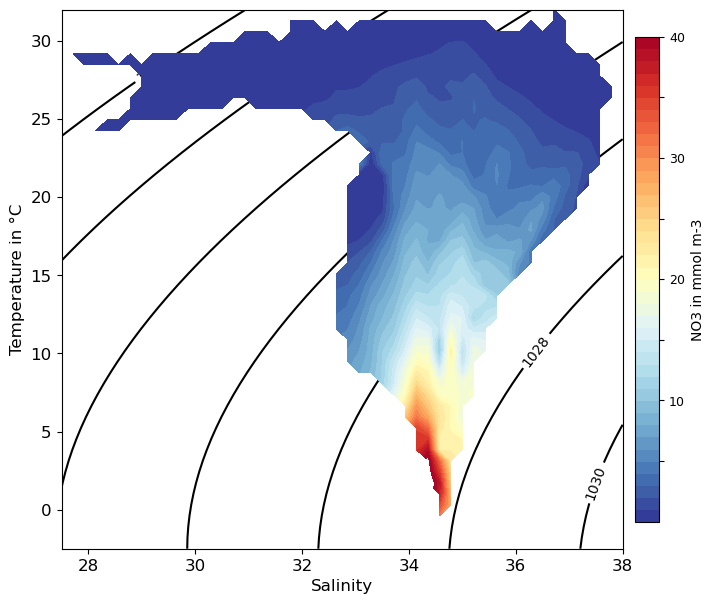

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_30S_30N_num_points_per_bin.png


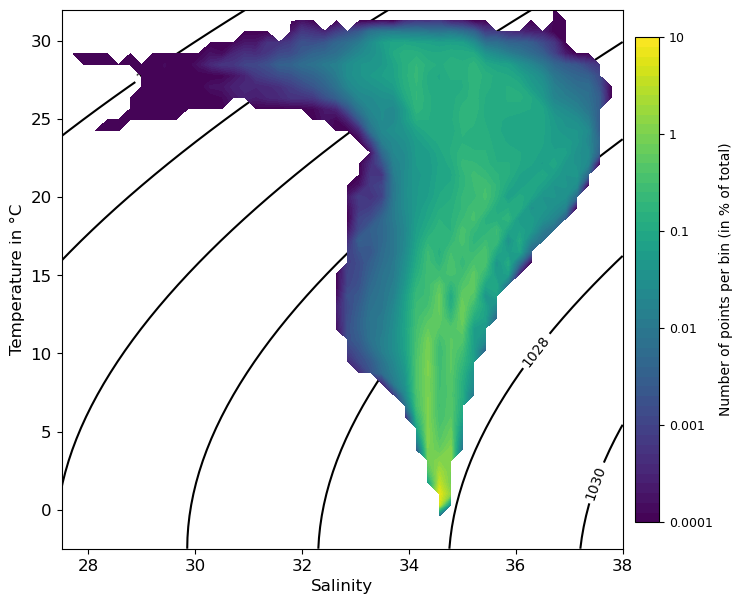

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_30S_30N_NO_LABELS.png


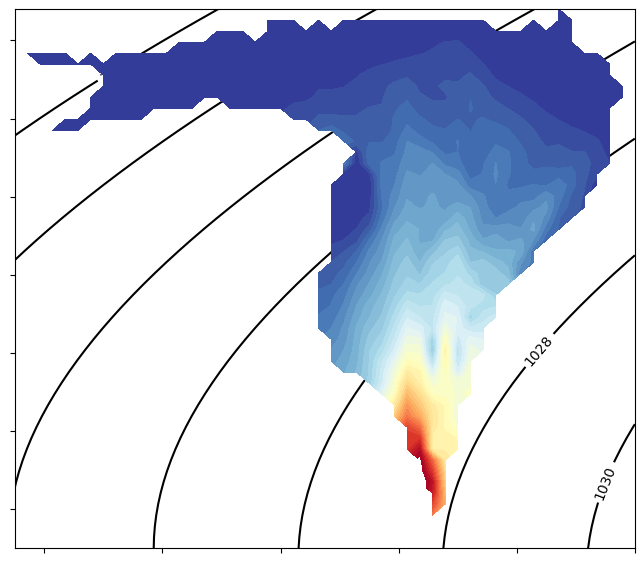

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_30S_30N_num_points_per_bin_NO_LABELS.png


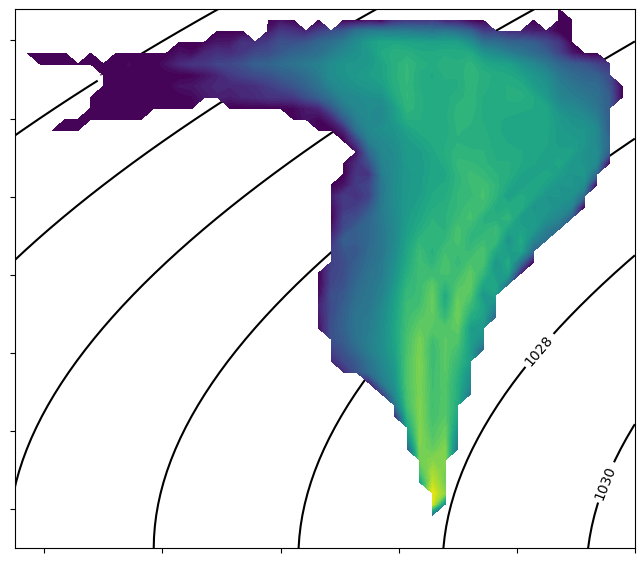

In [12]:
#---
# plot
# FLOATS
#---

plot_no_labels = True

cs = 2
fs = 12
cticks = [5,10,15,20,25,30,35,40]
ctickslabel = ['',10,'',20,'',30,'',40]

fig = plt.figure(figsize=(8,7))
sc=plt.contourf(salt_list,temp_list,no3_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,40+1,1))
cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
cbar.set_label('NO3 in mmol m-3',fontsize=fs-2)
cbar.ax.tick_params(labelsize=fs-3)
cbar.ax.set_yticklabels(ctickslabel) #['','','','',''])
cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
plt.xlabel('Salinity',fontsize=fs)
plt.ylabel('Temperature in °C',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[28,30,32,34,36,38],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[0,5,10,15,20,25,30],fontsize=fs)
if latstring in ['30_90S']:
    plt.xticks([32,33,34,35,36,37],[32,33,34,35,36,37],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if latstring in ['30_90N']:
    plt.xticks([28,30,32,34,36,38,40],[28,30,32,34,36,38,40],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_'+str(latstring)+'.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()



levels1 = np.arange(-4,1+0.1,0.1)
cticks = [-4,-3,-2,-1,0,1]
#ctickslabel = ['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$']#,'10$^{2}$']
ctickslabel = ['0.0001','0.001','0.01','0.1','1','10']

data_plot = np.copy(number_heat_map)
data_plot[data_plot==0]=np.nan
data_plot = np.log10(100*data_plot/np.nansum(data_plot))
data_plot[data_plot<levels1[0]] = levels1[0]+0.001

fig = plt.figure(figsize=(8,7))
sc=plt.contourf(salt_list,temp_list,data_plot,\
                cmap=plt.cm.viridis,levels=levels1) #levels=np.arange(0,2+0.1,0.1))
#sc=plt.contourf(salt_list,temp_list,number_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,80000+1000,1000))
cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
cbar.set_label('Number of points per bin (in % of total)',fontsize=fs-2)
cbar.ax.tick_params(labelsize=fs-3)
cbar.ax.set_yticklabels(ctickslabel)
cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
plt.xlabel('Salinity',fontsize=fs)
plt.ylabel('Temperature in °C',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[28,30,32,34,36,38],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[0,5,10,15,20,25,30],fontsize=fs)
if latstring in ['30_90S']:
    plt.xticks([32,33,34,35,36,37],[32,33,34,35,36,37],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if latstring in ['30_90N']:
    plt.xticks([28,30,32,34,36,38,40],[28,30,32,34,36,38,40],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_'+str(latstring)+'_num_points_per_bin.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()



if plot_no_labels:
    
    cs = 2
    fs = 12
    cticks = [5,10,15,20,25,30,35,40]
    ctickslabel = ['',10,'',20,'',30,'',40]

    fig = plt.figure(figsize=(8,7))
    sc=plt.contourf(salt_list,temp_list,no3_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,40+1,1))
    #cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
    #cbar.set_label('',fontsize=fs-2)
    #cbar.ax.tick_params(labelsize=fs-3)
    #cbar.ax.set_yticklabels([]) #['','','','',''])
    cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    if latstring in ['30S_30N']:
        plt.xticks([28,30,32,34,36,38],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25,30],[],fontsize=fs)
    if latstring in ['30_90S']:
        plt.xticks([32,33,34,35,36,37],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if latstring in ['30_90N']:
        plt.xticks([28,30,32,34,36,38,40],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if save_plots:
        filename = 'TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_'+str(latstring)+'_NO_LABELS.png'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
        del filename
    plt.show()



    levels1 = np.arange(-4,1+0.1,0.1)
    cticks = [-4,-3,-2,-1,0,1]
    #ctickslabel = ['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$']#,'10$^{2}$']
    ctickslabel = ['0.0001','0.001','0.01','0.1','1','10']

    data_plot = np.copy(number_heat_map)
    data_plot[data_plot==0]=np.nan
    data_plot = np.log10(100*data_plot/np.nansum(data_plot))
    data_plot[data_plot<levels1[0]] = levels1[0]+0.001

    fig = plt.figure(figsize=(8,7))
    sc=plt.contourf(salt_list,temp_list,data_plot,\
                    cmap=plt.cm.viridis,levels=levels1) #levels=np.arange(0,2+0.1,0.1))
    #sc=plt.contourf(salt_list,temp_list,number_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,80000+1000,1000))
    #cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
    #cbar.set_label('',fontsize=fs-2)
    #cbar.ax.tick_params(labelsize=fs-3)
    #cbar.ax.set_yticklabels([])
    cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    if latstring in ['30S_30N']:
        plt.xticks([28,30,32,34,36,38],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25,30],[],fontsize=fs)
    if latstring in ['30_90S']:
        plt.xticks([32,33,34,35,36,37],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if latstring in ['30_90N']:
        plt.xticks([28,30,32,34,36,38,40],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if save_plots:
        filename = 'TS_diagram_heat_map_E3SM_floats_2016_vs_nitrate_'+str(latstring)+'_num_points_per_bin_NO_LABELS.png'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
        del filename
    plt.show()



/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_30S_30N.png


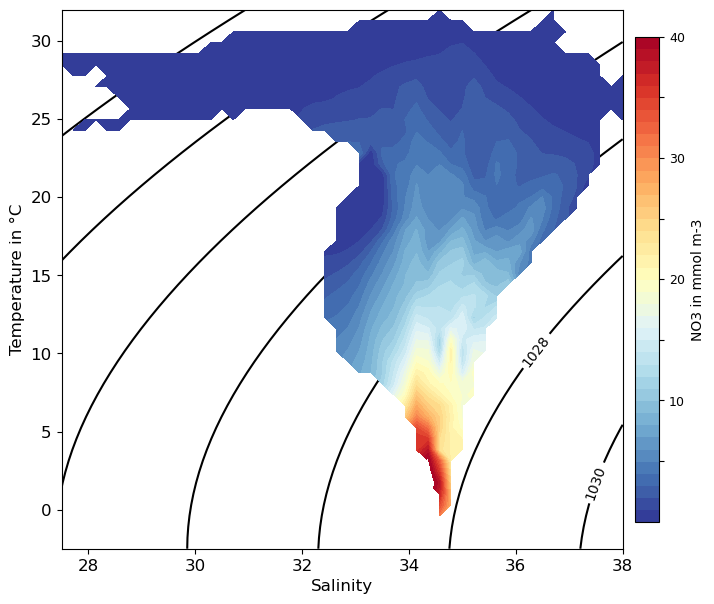

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_30S_30N_num_points_per_bin.png


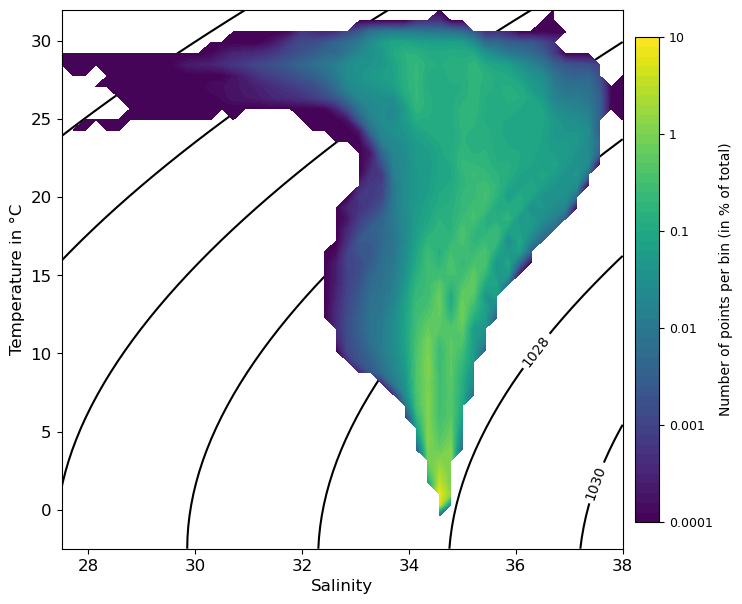

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_30S_30N_NO_LABELS.png


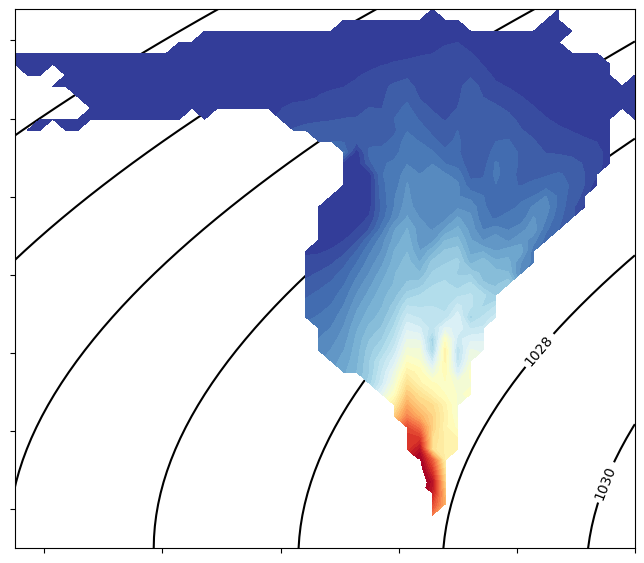

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_30S_30N_COLORBAR.eps


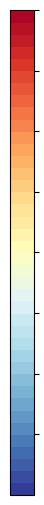

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_30S_30N_num_points_per_bin_NO_LABELS.png


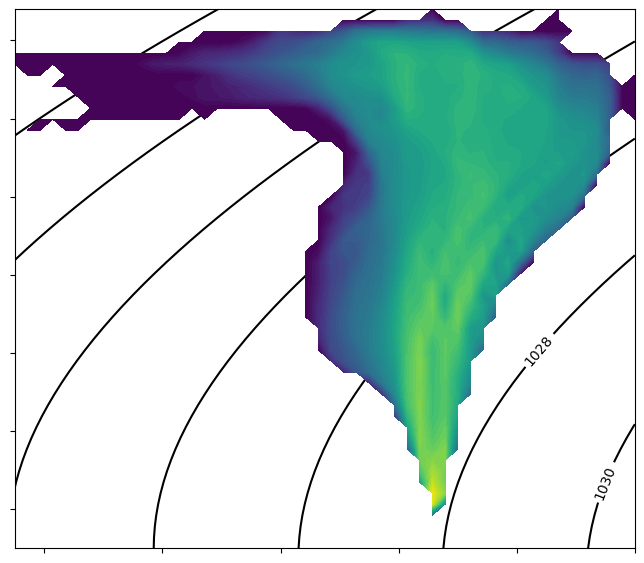

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_30S_30N_num_points_per_bin_COLORBAR.eps


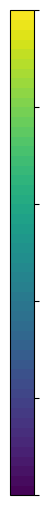

In [13]:
#---
# plot
# EULERIAN
#---

cs = 2
fs = 12
cticks = [5,10,15,20,25,30,35,40]
ctickslabel = ['',10,'',20,'',30,'',40]

fig = plt.figure(figsize=(8,7))
sc=plt.contourf(salt_list,temp_list,no3_heat_map_euler,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,40+1,1))
cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
cbar.set_label('NO3 in mmol m-3',fontsize=fs-2)
cbar.ax.tick_params(labelsize=fs-3)
cbar.ax.set_yticklabels(ctickslabel) #['','','','',''])
cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
plt.xlabel('Salinity',fontsize=fs)
plt.ylabel('Temperature in °C',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[28,30,32,34,36,38],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[0,5,10,15,20,25,30],fontsize=fs)
if latstring in ['30_90S']:
    plt.xticks([32,33,34,35,36,37],[32,33,34,35,36,37],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if latstring in ['30_90N']:
    plt.xticks([28,30,32,34,36,38,40],[28,30,32,34,36,38,40],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_'+str(latstring)+'.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()


levels1 = np.arange(-4,1+0.1,0.1)
cticks = [-4,-3,-2,-1,0,1]
#ctickslabel = ['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$']#,'10$^{2}$']
ctickslabel = ['0.0001','0.001','0.01','0.1','1','10']

data_plot = np.copy(number_heat_map_euler)
data_plot[data_plot==0]=np.nan
data_plot = np.log10(100*data_plot/np.nansum(data_plot))
data_plot[data_plot<levels1[0]] = levels1[0]+0.001

fig = plt.figure(figsize=(8,7))
sc=plt.contourf(salt_list,temp_list,data_plot,\
                cmap=plt.cm.viridis,levels=levels1) #levels=np.arange(0,2+0.1,0.1))
#sc=plt.contourf(salt_list,temp_list,number_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,80000+1000,1000))
cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
cbar.set_label('Number of points per bin (in % of total)',fontsize=fs-2)
cbar.ax.tick_params(labelsize=fs-3)
cbar.ax.set_yticklabels(ctickslabel)
cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
plt.xlabel('Salinity',fontsize=fs)
plt.ylabel('Temperature in °C',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[28,30,32,34,36,38],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[0,5,10,15,20,25,30],fontsize=fs)
if latstring in ['30_90S']:
    plt.xticks([32,33,34,35,36,37],[32,33,34,35,36,37],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if latstring in ['30_90N']:
    plt.xticks([28,30,32,34,36,38,40],[28,30,32,34,36,38,40],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_'+str(latstring)+'_num_points_per_bin.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()


if plot_no_labels:
    
    cs = 2
    fs = 12
    cticks = [5,10,15,20,25,30,35,40]
    ctickslabel = ['',10,'',20,'',30,'',40]

    fig = plt.figure(figsize=(8,7))
    sc=plt.contourf(salt_list,temp_list,no3_heat_map_euler,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,40+1,1))
    #cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
    #cbar.set_label('NO3 in mmol m-3',fontsize=fs-2)
    #cbar.ax.tick_params(labelsize=fs-3)
    #cbar.ax.set_yticklabels(ctickslabel) #['','','','',''])
    cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    if latstring in ['30S_30N']:
        plt.xticks([28,30,32,34,36,38],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25,30],[],fontsize=fs)
    if latstring in ['30_90S']:
        plt.xticks([32,33,34,35,36,37],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if latstring in ['30_90N']:
        plt.xticks([28,30,32,34,36,38,40],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if save_plots:
        filename = 'TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_'+str(latstring)+'_NO_LABELS.png'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
        del filename
    plt.show()
    
    #---
    # colorbar separately, save as eps
    #---
    fig = plt.figure(figsize=(8,7))
    sc=plt.contourf(salt_list,temp_list,no3_heat_map_euler,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,40+1,1))
    plt.gca().set_visible(False)
    cbar = plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
    #cbar.set_label('NO3 in mmol m-3',fontsize=fs-2)
    cbar.ax.tick_params(labelsize=fs-3)
    cbar.ax.set_yticklabels([])
    if save_plots:
        filename = 'TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_'+str(latstring)+'_COLORBAR.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename
    plt.show()


    levels1 = np.arange(-4,1+0.1,0.1)
    cticks = [-4,-3,-2,-1,0,1]
    #ctickslabel = ['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$']#,'10$^{2}$']
    ctickslabel = ['0.0001','0.001','0.01','0.1','1','10']

    data_plot = np.copy(number_heat_map_euler)
    data_plot[data_plot==0]=np.nan
    data_plot = np.log10(100*data_plot/np.nansum(data_plot))
    data_plot[data_plot<levels1[0]] = levels1[0]+0.001

    fig = plt.figure(figsize=(8,7))
    sc=plt.contourf(salt_list,temp_list,data_plot,\
                    cmap=plt.cm.viridis,levels=levels1) #levels=np.arange(0,2+0.1,0.1))
    #sc=plt.contourf(salt_list,temp_list,number_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,80000+1000,1000))
    #cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
    #cbar.set_label('',fontsize=fs-2)
    #cbar.ax.tick_params(labelsize=fs-3)
    #cbar.ax.set_yticklabels([])
    cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    if latstring in ['30S_30N']:
        plt.xticks([28,30,32,34,36,38],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25,30],[],fontsize=fs)
    if latstring in ['30_90S']:
        plt.xticks([32,33,34,35,36,37],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if latstring in ['30_90N']:
        plt.xticks([28,30,32,34,36,38,40],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if save_plots:
        filename = 'TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_'+str(latstring)+'_num_points_per_bin_NO_LABELS.png'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
        del filename
    plt.show()
    
    #---
    # colorbar separately, save as eps
    #---
    fig = plt.figure(figsize=(8,7))
    sc=plt.contourf(salt_list,temp_list,data_plot,\
                    cmap=plt.cm.viridis,levels=levels1) #levels=np.arange(0,2+0.1,0.1))
    plt.gca().set_visible(False)
    cbar = plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
    #cbar.set_label('NO3 in mmol m-3',fontsize=fs-2)
    cbar.ax.tick_params(labelsize=fs-3)
    cbar.ax.set_yticklabels([])
    if save_plots:
        filename = 'TS_diagram_heat_map_E3SM_Eulerian_2016_vs_nitrate_'+str(latstring)+'_num_points_per_bin_COLORBAR.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename
    plt.show()


In [14]:
#---
# real-world ARGO data -> load all temp/salinity data
#---
# get all trejectories between 2012-2017
# only consider profiles for which I have both temp & salinity
#

path1 = '/pscratch/sd/c/cnissen/ARGO_floats/download_April2023/202303-ArgoData/dac/'

year1,year2 = 2012,2017 #2017

# initialize arrays
lon_float_all    = [] 
lat_float_all    = []
year_floats_all  = []
temp_floats_all  = []
salt_floats_all  = []
floatID_all      = []

# get a list of all folders
subdir = next(os.walk(path1))[1]
print(subdir)

for ss in range(0,len(subdir)):
    
    # only continue if it is a "core" folder
    if 'core' in subdir[ss]: 
        print('Process ',subdir[ss])
        subdir2 = next(os.walk(path1+subdir[ss]))[1] # list of all subfolders (aoml, coriolis etc.)
        
        print('Loop over '+str(len(subdir2))+' subfolders')
        for tt in tqdm(range(0,len(subdir2))):
            
            # check existence of file, if it does not exist, continue to next iteration of the loop
            fname = path1+subdir[ss]+'/'+subdir2[tt]+'/'+subdir2[tt]+'_prof.nc'
            if os.path.isfile(fname):
                f1 = xr.open_dataset(fname)
                lat_float   = f1['LATITUDE'].values
                lon_float   = f1['LONGITUDE'].values
                time_float  = f1['JULD'].values
                try:
                    temp_float  = f1['TEMP'].values
                except: 
                    #print('Temperature not in file',fname)
                    continue
                try:
                    salt_float  = f1['PSAL'].values
                except: 
                    #print('Salinity not in file',fname)
                    continue
                temp_qc  = f1['TEMP_QC'].values
                salt_qc  = f1['PSAL_QC'].values
                pres_float  = f1['PRES'].values
                f1.close()
                
                # kick out NaNs
                ind_not_NaN = np.where(~np.isnan(lon_float))[0]
                lon_float   = lon_float[ind_not_NaN]
                lat_float   = lat_float[ind_not_NaN]
                time_float  = time_float[ind_not_NaN]
                temp_float  = temp_float[ind_not_NaN,:]
                salt_float  = salt_float[ind_not_NaN,:]
                temp_qc  = temp_qc[ind_not_NaN,:]
                salt_qc  = salt_qc[ind_not_NaN,:]
                pres_float = pres_float[ind_not_NaN,:]
                
                del ind_not_NaN
                # problem with this: I need to know how long the data gap was. 
                #   otherwise, I cannot convert "travelled distance"
                #   into velocities
                # store year/month/day for each profile and go through the data later

                # find all profiles for time period of interest
                ind_profiles = []
                list_years   = []
                list_months  = []
                list_days    = []
                for dd in range(0,len(time_float)):
                    #print(int(str(time_float[dd])[0:4]))
                    
                    # some files had "NaT" in them. 
                    # if that is the case, choose an index close to the current one to determine 
                    # whether I am interested in the current profile
                    try:
                        time_aux = str(time_float[dd])[0:4]
                    except: # If the above does not work, entry is "NaT"
                        time_aux = 'NaT'
                    #if time_aux in ['NaT']:
                    #    time_aux2 = str(time_float[dd+1])[0:4]
                    #else:
                    #    time_aux2 = str(time_float[dd])[0:4]
    
                    if time_aux not in ['NaT']:
                        if (int(time_aux)>=year1) & (int(time_aux)<=year2):
                            list_years   = np.hstack((list_years,int(str(time_float[dd])[0:4])))
                            list_months  = np.hstack((list_months,int(str(time_float[dd])[5:7])))
                            list_days    = np.hstack((list_days,int(str(time_float[dd])[8:10])))
                            ind_profiles = np.hstack((ind_profiles,int(dd)))
                            
                ind_profiles = [int(x) for x in ind_profiles]

                # only continue if there is profiles for years of interest
                if len(ind_profiles)>0:
                    lat_float  = lat_float[ind_profiles]
                    lon_float  = lon_float[ind_profiles]
                    time_float = time_float[ind_profiles]
                    temp_float = temp_float[ind_profiles,:]
                    salt_float = salt_float[ind_profiles,:]
                    temp_qc = temp_qc[ind_profiles,:]
                    salt_qc = salt_qc[ind_profiles,:]
                    pres_float = pres_float[ind_profiles,:]

                    #----
                    # FILTER for QC
                    #----
                    # only keep 'very good' data
                    #
                #    auxtemp = temp_float.ravel()
                #    auxtempqc = temp_qc.ravel()
                #    auxtempqc_int = np.zeros_like(auxtempqc)
                #    for kk in range(0,auxtempqc.shape[0]):
                #        try:
                #            auxtempqc_int[kk] = int(auxtempqc[kk])
                #        except:
                #            pass
                #    del auxtempqc
                #    auxsalt = salt_float.ravel()
                #    auxsaltqc = salt_qc.ravel()
                #    auxsaltqc_int = np.zeros_like(auxsaltqc)
                #    for kk in range(0,auxsaltqc.shape[0]):
                #        try:
                #            auxsaltqc_int[kk] = int(auxsaltqc[kk])
                #        except:
                #            pass
                #    del auxsaltqc
                    
                    auxtemp = temp_float.ravel()
                    auxtempqc = temp_qc#.ravel()
                    auxtempqc_int = np.zeros_like(auxtempqc)
                    for kk in range(0,auxtempqc.shape[0]):
                        for ll in range(0,auxtempqc.shape[1]):
                            try:
                                auxtempqc_int[kk,ll] = int(auxtempqc[kk,ll])
                            except:
                                pass
                    del auxtempqc
                    auxsalt = salt_float.ravel()
                    auxsaltqc = salt_qc#.ravel()
                    auxsaltqc_int = np.zeros_like(auxsaltqc)
                    for kk in range(0,auxsaltqc.shape[0]):
                        for ll in range(0,auxsaltqc.shape[1]):
                            try:
                                auxsaltqc_int[kk,ll] = int(auxsaltqc[kk,ll])
                            except:
                                pass
                    del auxsaltqc
                    
                    
                    # qc=1 is very good data (has passed all qc checks)
                    ind1 = np.where(auxtempqc_int==1)[0]
                    ind2 = np.where(auxsaltqc_int==1)[0]
                    # find indices that are qc=1 in both
                    overlap = np.array(list(set(ind1).intersection(ind2)))
                    if overlap.shape[0]>0: # only continue if there is any good data
                        
                        # set all occassions to kick out to NaN
                        #print(temp_float.shape)
                        ind1b = np.where(auxtempqc_int!=1)#[0]
                        ind2b = np.where(auxsaltqc_int!=1)#[0]
                        temp_float[ind1b] = np.nan
                        temp_float[ind2b] = np.nan
                        salt_float[ind1b] = np.nan
                        salt_float[ind2b] = np.nan
                        pres_float[ind1b] = np.nan
                        pres_float[ind2b] = np.nan
                        #print(temp_float.shape)
                                               
                        #---
                        # SOMETHINGS STILL GOES WRONG HERE
                        # the final arrays only contain zeros...
                        # CHECK
                        #----
                            
                        # interpolate to model zlev (to reduce the number of depth levels stored... some floats have 1000 entries in the vertical!)
                        aux4b = np.zeros([temp_float.shape[0],46]) # 46 zelvs up until 2074m in E3SM setup
                        aux5b = np.zeros([salt_float.shape[0],46]) 
                        for zz in range(0,temp_float.shape[0]): # loop over all profiles
                            xs = pres_float[zz,:]
                            ys = temp_float[zz,:]
                            if np.sum(~np.isnan(xs))>1: # if any depth levels are left
                                if np.nanmax(xs)>np.min(zlevs):
                                    #print(xs)
                                    #try:
                                    
                                    ind_dd = np.where((np.nanmax(xs)-zlevs[0:46])>0)[0][-1] # find the deepest available depth in float data -> cannot extrapolate!
                                    ind_dd2= np.where((np.nanmin(xs)-zlevs[0:46])<0)[0][0] # shallow: if first model level is shallower than first float level, correct here
                                    #print(ind_dd,ind_dd2)
                                    interp_func = interp1d(xs, ys)
                                    aux4b[zz,ind_dd2:ind_dd] = interp_func(zlevs[ind_dd2:ind_dd])
                                    #print('interpolated',aux4b[zz,ind_dd2:ind_dd])
                                    del interp_func,ys
                                    ys = salt_float[zz,:]
                                    interp_func = interp1d(xs, ys)
                                    aux5b[zz,ind_dd2:ind_dd] = interp_func(zlevs[ind_dd2:ind_dd])
                                    del interp_func,ys
                                    #except: # it fails if float only contains depth levels outside of model depth levels
                                    #    pass
                                #else:
                                #    print(np.nanmax(xs))
                        
                        aux4 = aux4b.ravel() #temp_float.ravel()[overlap]
                        aux5 = aux5b.ravel() #salt_float.ravel()[overlap]
                        del ind1,ind2,auxsaltqc_int,auxtempqc_int

                        #----
                        # store info in array
                        #----
                        aux1 = np.tile(lat_float,[aux4b.shape[1],1]).transpose().ravel() #[overlap]
                        aux2 = np.tile(lon_float,[aux4b.shape[1],1]).transpose().ravel() #[overlap]
                        aux3 = np.tile(list_years,[aux4b.shape[1],1]).transpose().ravel() #[overlap]
                        #reduce to current lat range
                        ind_reg = np.where((aux1.ravel()<=latlim1) & (aux1.ravel()>=latlim2))[0]
                        aux1 = aux1[ind_reg]
                        aux2 = aux2[ind_reg]
                        aux3 = aux3[ind_reg]
                        aux4 = aux4[ind_reg]
                        aux5 = aux5[ind_reg]
                        
                        ind0 = np.where(aux4==0)[0]
                        if ind0.shape[0]>0:
                            #print(ind0)
                            aux1 = np.delete(aux1,ind0)
                            aux2 = np.delete(aux2,ind0)
                            aux3 = np.delete(aux3,ind0)
                            aux4 = np.delete(aux4,ind0)
                            aux5 = np.delete(aux5,ind0)  
                            #print(np.min(aux4),np.max(aux4))
                        
                        if len(aux4)>0:
                            lat_float_all     = np.hstack((lat_float_all,aux1))
                            lon_float_all     = np.hstack((lon_float_all,aux2))
                            year_floats_all   = np.hstack((year_floats_all,aux3))
                            temp_floats_all   = np.hstack((temp_floats_all,aux4))
                            salt_floats_all   = np.hstack((salt_floats_all,aux5))
                        #try:
                        #    if len(aux4)>0:
                        #        print(np.min(temp_floats_all),np.max(temp_floats_all))
                        #except:
                        #    pass
                        #floatID_all       = np.hstack((floatID_all,int(subdir2[tt])*np.ones(len(lat_float[:-1]))))
                        del aux1,aux2,aux3,aux4,aux5
                    del overlap,list_days,list_months,list_years
                    
                del lat_float,lon_float,time_float,ind_profiles
                #del temp_qc,salt_qc,temp_float,salt_float
            else:
                continue
    print('Current number of data points:',temp_floats_all.shape[0])
    
            
print('done')
            
# if the "NaT" keeps causing problems: check if lat/lon containt NaNs. If yes, filter profiles first to exclude NaNs...
# I would assume though that the "find distance" function would crash if there was NaNs...
    
# 36.45it/s
# 37.75it/s
    

['csio_core', 'incois_core', 'coriolis_bgc', 'incois_bgc', 'bodc_core', 'jma_bgc', 'jma_core', 'csio_bgc', 'meds_bgc', 'kma_core', 'nmdis_core', 'bodc_bgc', 'csiro_bgc', 'csiro_core', 'aoml_core', 'coriolis_core', 'meds_core', 'EXTRACTED', 'kordi_bgc', 'aoml_bgc', 'kma_bgc', 'kordi_core']
Process  csio_core
Loop over 526 subfolders


100%|██████████| 526/526 [00:29<00:00, 17.82it/s]


Current number of data points: 1374843
Process  incois_core
Loop over 491 subfolders


100%|██████████| 491/491 [00:29<00:00, 16.57it/s]


Current number of data points: 2356786
Current number of data points: 2356786
Current number of data points: 2356786
Process  bodc_core
Loop over 849 subfolders


100%|██████████| 849/849 [00:49<00:00, 17.05it/s]


Current number of data points: 2903264
Current number of data points: 2903264
Process  jma_core
Loop over 1894 subfolders


100%|██████████| 1894/1894 [02:01<00:00, 15.58it/s]


Current number of data points: 4071370
Current number of data points: 4071370
Current number of data points: 4071370
Process  kma_core
Loop over 259 subfolders


100%|██████████| 259/259 [00:12<00:00, 20.21it/s]


Current number of data points: 4129908
Process  nmdis_core
Loop over 19 subfolders


100%|██████████| 19/19 [00:02<00:00,  8.82it/s]


Current number of data points: 4191201
Current number of data points: 4191201
Current number of data points: 4191201
Process  csiro_core
Loop over 1120 subfolders


100%|██████████| 1120/1120 [02:38<00:00,  7.08it/s]


Current number of data points: 5571229
Process  aoml_core
Loop over 8462 subfolders


100%|██████████| 8462/8462 [20:01<00:00,  7.05it/s]


Current number of data points: 16940787
Process  coriolis_core
Loop over 3602 subfolders


100%|██████████| 3602/3602 [07:11<00:00,  8.34it/s]


Current number of data points: 18648804
Process  meds_core
Loop over 651 subfolders


100%|██████████| 651/651 [00:29<00:00, 22.03it/s]


Current number of data points: 18650692
Current number of data points: 18650692
Current number of data points: 18650692
Current number of data points: 18650692
Current number of data points: 18650692
Process  kordi_core
Loop over 115 subfolders


100%|██████████| 115/115 [00:04<00:00, 28.23it/s]

Current number of data points: 18650692
done


In [15]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/


In [16]:
#---
# produce a heat map of ARGO data availability for chosen region
# FLOATS (no area-weighting needed)
#---

num = 50
temp_list = np.linspace(ylim1,ylim2,num) #np.arange(ylim1,ylim2+0.25,0.25)
salt_list = np.linspace(xlim1,xlim2,num) #np.arange(xlim1,xlim2+0.25,0.25)
salt_list,temp_list = np.meshgrid(salt_list,temp_list )
density = dens(salt_list,temp_list,0)

ind_reg = np.where((lat_float_all.ravel()<=latlim1) & (lat_float_all.ravel()>=latlim2))[0]
print(ind.shape[0])
ind_not_NaN = np.where(~np.isnan(salt_floats_all.ravel()[ind_reg]))[0]

salt_data = salt_floats_all.ravel()[ind_reg][ind_not_NaN]
temp_data = temp_floats_all.ravel()[ind_reg][ind_not_NaN]

number_heat_map_argo = np.nan*np.ones_like(salt_list) # save how many points are available in each box
for mm in tqdm(range(0,temp_list.shape[0])): # temp
    for nn in range(0,salt_list.shape[1]): # salt
        tt_aux1 = temp_list[mm,nn]
        ss_aux1 = salt_list[mm,nn]
        try: 
            tt_aux2 = temp_list[mm+1,nn]
        except: 
            tt_aux2 = 100 # set to a random high number
        try: 
            ss_aux2 = salt_list[mm,nn+1]
        except: 
            ss_aux2 = 100 # set to a random high number
                
        ind1 = np.where((salt_data>=ss_aux1) & (salt_data<ss_aux2) & (temp_data>=tt_aux1) & (temp_data<tt_aux2))[0]

        number_heat_map_argo[mm,nn] = ind1.shape[0]
        
print('done')



46


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]

done


/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_core_Argo_2012_2017_30S_30N.png


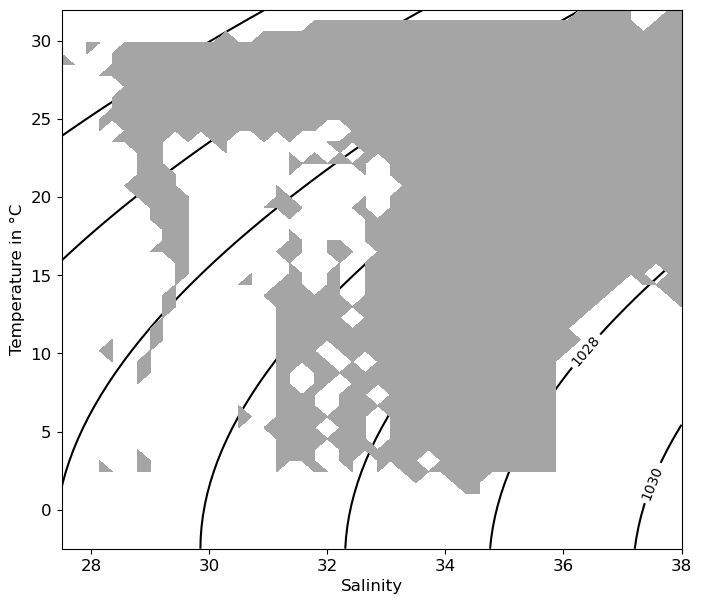

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_core_Argo_2012_2017_30S_30N_num_points_per_bin.png


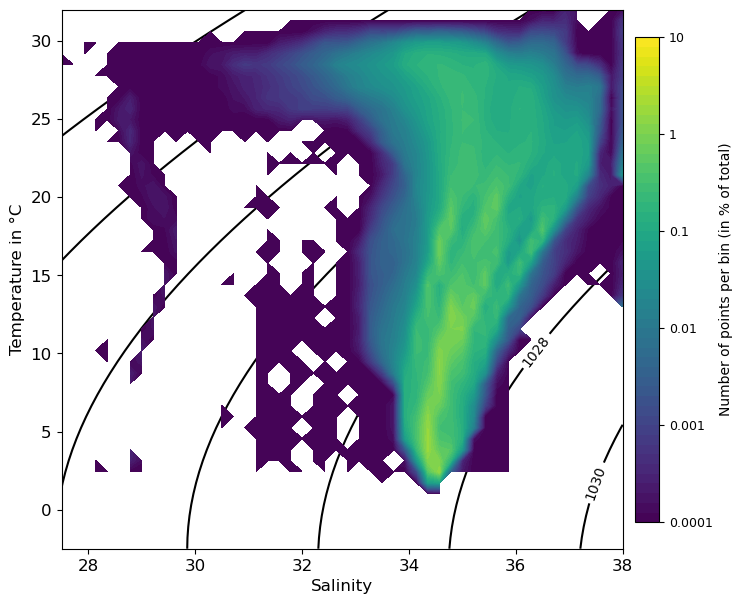

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_core_Argo_2012_2017_30S_30N_NO_LABELS.png


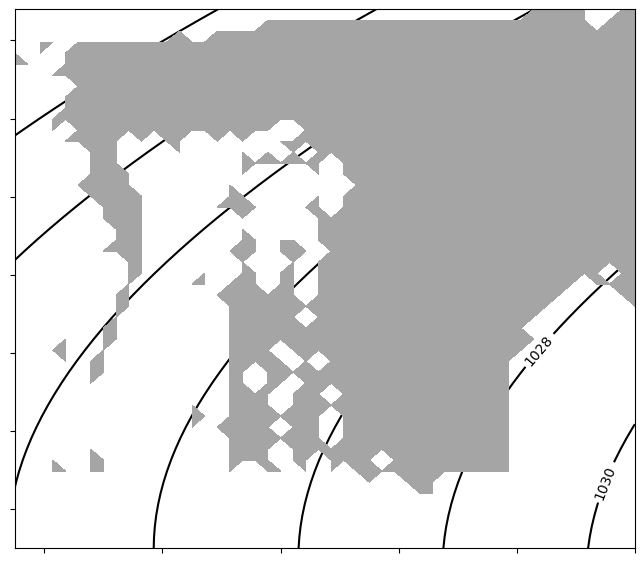

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_heat_map_core_Argo_2012_2017_30S_30N_num_points_per_bin_NO_LABELS.png


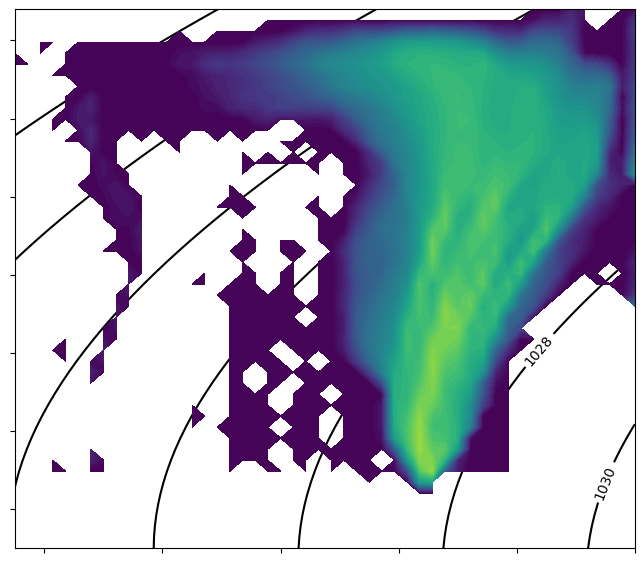

In [17]:
#---
# plot data distribution Argo
#---

plot_no_labels = True
save_plots = True

cs = 2
fs = 12
cticks = [5,10,15,20,25,30,35,40]
ctickslabel = ['',10,'',20,'',30,'',40]

data_plot = np.zeros_like(number_heat_map_argo)
data_plot[number_heat_map_argo>0] = 1

fig = plt.figure(figsize=(8,7))
data_plot = np.ma.masked_where(data_plot==0,data_plot)
sc=plt.contourf(salt_list,temp_list,data_plot,cmap=plt.cm.Greys,levels=np.arange(0,2+0.2,0.2))
cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
plt.xlabel('Salinity',fontsize=fs)
plt.ylabel('Temperature in °C',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[28,30,32,34,36,38],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[0,5,10,15,20,25,30],fontsize=fs)
if latstring in ['30_90S']:
    plt.xticks([32,33,34,35,36,37],[32,33,34,35,36,37],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if latstring in ['30_90N']:
    plt.xticks([28,30,32,34,36,38,40],[28,30,32,34,36,38,40],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_heat_map_core_Argo_2012_2017_'+str(latstring)+'.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()



levels1 = np.arange(-4,1+0.1,0.1)
cticks = [-4,-3,-2,-1,0,1]
#ctickslabel = ['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$']#,'10$^{2}$']
ctickslabel = ['0.0001','0.001','0.01','0.1','1','10']

data_plot = np.copy(number_heat_map_argo)
data_plot[data_plot==0]=np.nan
data_plot = np.log10(100*data_plot/np.nansum(data_plot))
data_plot[data_plot<levels1[0]] = levels1[0]+0.001

fig = plt.figure(figsize=(8,7))
sc=plt.contourf(salt_list,temp_list,data_plot,\
                cmap=plt.cm.viridis,levels=levels1) #levels=np.arange(0,2+0.1,0.1))
#sc=plt.contourf(salt_list,temp_list,number_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,80000+1000,1000))
cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
cbar.set_label('Number of points per bin (in % of total)',fontsize=fs-2)
cbar.ax.tick_params(labelsize=fs-3)
cbar.ax.set_yticklabels(ctickslabel)
cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
plt.xlabel('Salinity',fontsize=fs)
plt.ylabel('Temperature in °C',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[28,30,32,34,36,38],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[0,5,10,15,20,25,30],fontsize=fs)
if latstring in ['30_90S']:
    plt.xticks([32,33,34,35,36,37],[32,33,34,35,36,37],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if latstring in ['30_90N']:
    plt.xticks([28,30,32,34,36,38,40],[28,30,32,34,36,38,40],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[0,5,10,15,20,25],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_heat_map_core_Argo_2012_2017_'+str(latstring)+'_num_points_per_bin.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()



if plot_no_labels:
    
    cs = 2
    fs = 12
    cticks = [5,10,15,20,25,30,35,40]
    ctickslabel = ['',10,'',20,'',30,'',40]

    data_plot = np.zeros_like(number_heat_map_argo)
    data_plot[number_heat_map_argo>0] = 1

    fig = plt.figure(figsize=(8,7))
    data_plot = np.ma.masked_where(data_plot==0,data_plot)
    sc=plt.contourf(salt_list,temp_list,data_plot,cmap=plt.cm.Greys,levels=np.arange(0,2+0.2,0.2))
    cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    if latstring in ['30S_30N']:
        plt.xticks([28,30,32,34,36,38],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25,30],[],fontsize=fs)
    if latstring in ['30_90S']:
        plt.xticks([32,33,34,35,36,37],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if latstring in ['30_90N']:
        plt.xticks([28,30,32,34,36,38,40],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if save_plots:
        filename = 'TS_diagram_heat_map_core_Argo_2012_2017_'+str(latstring)+'_NO_LABELS.png'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
        del filename
    plt.show()



    levels1 = np.arange(-4,1+0.1,0.1)
    cticks = [-4,-3,-2,-1,0,1]
    #ctickslabel = ['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$']#,'10$^{2}$']
    ctickslabel = ['0.0001','0.001','0.01','0.1','1','10']

    data_plot = np.copy(number_heat_map_argo)
    data_plot[data_plot==0]=np.nan
    data_plot = np.log10(100*data_plot/np.nansum(data_plot))
    data_plot[data_plot<levels1[0]] = levels1[0]+0.001

    fig = plt.figure(figsize=(8,7))
    sc=plt.contourf(salt_list,temp_list,data_plot,\
                    cmap=plt.cm.viridis,levels=levels1) #levels=np.arange(0,2+0.1,0.1))
    #sc=plt.contourf(salt_list,temp_list,number_heat_map,cmap=plt.cm.RdYlBu_r,levels=np.arange(0,80000+1000,1000))
    #cbar = plt.colorbar(sc,orientation='vertical',fraction=0.075, pad=0.02,shrink=0.9,ticks=cticks)
    #cbar.set_label('',fontsize=fs-2)
    #cbar.ax.tick_params(labelsize=fs-3)
    #cbar.ax.set_yticklabels([])
    cs=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%d',zorder=0)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    if latstring in ['30S_30N']:
        plt.xticks([28,30,32,34,36,38],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25,30],[],fontsize=fs)
    if latstring in ['30_90S']:
        plt.xticks([32,33,34,35,36,37],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if latstring in ['30_90N']:
        plt.xticks([28,30,32,34,36,38,40],[],fontsize=fs)
        plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
    if save_plots:
        filename = 'TS_diagram_heat_map_core_Argo_2012_2017_'+str(latstring)+'_num_points_per_bin_NO_LABELS.png'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
        del filename
    plt.show()



(139, 43)
(139, 43) 1015.4341566301572 1030.6465856830237
Available points: 18650692
Points to plot: 5000000
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_ARGO_floats_2012_2017_num_points_ALL_30S_30N.png


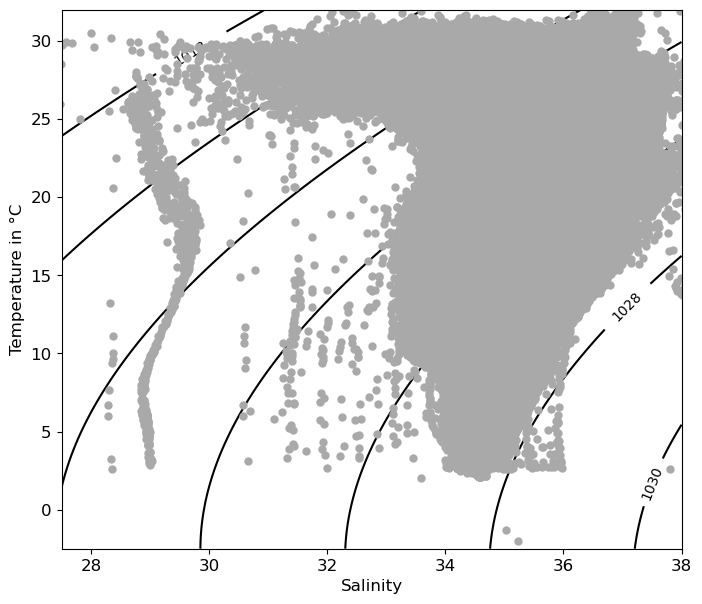

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/T_S_diagrams_v2/heat_map/TS_diagram_ARGO_floats_2012_2017_num_points_ALL_30S_30N_v2.png


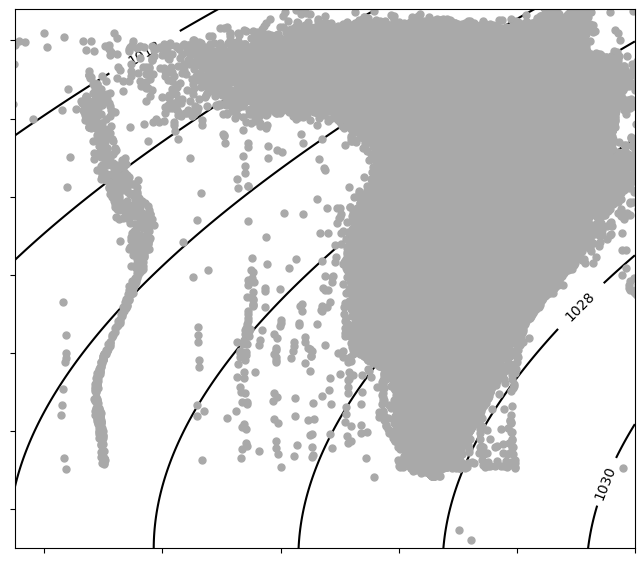

In [21]:
#----
# plot T-S-diagram, REAL-WORLD FLOATS
#----
# NOTE: 
#   these data are only for the top 2000m
#     -> for better comparison, also plot E3SM data for top 2000m!
#

#aux_lat = np.tile(lat,[60,1]).transpose()
#ind_reg = np.where((aux_lat.ravel()<=latlim1) & (aux_lat.ravel()>=latlim2))[0]
#print(ind.shape[0])

#ind_not_NaN = salt.ravel().mask==False #np.where(~np.isnan(salt_2.ravel()[ind_reg]))[0]
    
temp_list = np.arange(ylim1,ylim2+0.25,0.25)
salt_list = np.arange(xlim1,xlim2+0.25,0.25)
salt_list,temp_list = np.meshgrid(salt_list,temp_list )
print(temp_list.shape)

density = dens(salt_list,temp_list,0)
print(density.shape,np.min(density),np.max(density))

num_points_plot = 5000000 #len(salt_floats_all.ravel()) #num_av_points #

print('Available points:',len(temp_floats_all.ravel())) #[ind_reg][ind_not_NaN]
print('Points to plot:',num_points_plot)
ind_av = np.arange(0,len(salt_floats_all.ravel())) #[ind_reg][ind_not_NaN]
ind_random  = np.random.choice(ind_av, size=num_points_plot, replace=False)
        
cs = 2
fs = 12
ms = 5

fig = plt.figure(figsize=(8,7))
#plt.scatter(salt_floats_all.ravel()[ind_random],temp_floats_all.ravel()[ind_random],\
#            s=cs,c=no3.ravel()[ind_reg][ind_not_NaN][ind_random],cmap=plt.cm.RdYlBu_r,vmin=0,vmax=40)
plt.plot(salt_floats_all.ravel()[ind_random],temp_floats_all.ravel()[ind_random],\
            color='darkgrey',marker='o',linewidth=0,markersize=ms)
cs2=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
labels1=plt.clabel(cs2, inline=1, fontsize=10, fmt='%d',zorder=0,use_clabeltext=True)
#for l in labels1:
#    l.set_rotation(0)
plt.xlabel('Salinity',fontsize=fs)
plt.ylabel('Temperature in °C',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[28,30,32,34,36,38],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[0,5,10,15,20,25,30],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_ARGO_floats_2012_2017_num_points_ALL_'+str(latstring)+'.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()

#---
# no LABELS
#---
fig = plt.figure(figsize=(8,7))
#plt.scatter(salt_floats_all.ravel()[ind_random],temp_floats_all.ravel()[ind_random],\
#            s=cs,c=no3.ravel()[ind_reg][ind_not_NaN][ind_random],cmap=plt.cm.RdYlBu_r,vmin=0,vmax=40)
plt.plot(salt_floats_all.ravel()[ind_random],temp_floats_all.ravel()[ind_random],\
            color='darkgrey',marker='o',linewidth=0,markersize=ms)
cs2=plt.contour(salt_list,temp_list,density,[1018,1020,1022,1024,1026,1028,1030],colors='k',zorder=0)
labels1=plt.clabel(cs2, inline=1, fontsize=10, fmt='%d',zorder=0,use_clabeltext=True)
#for l in labels1:
#    l.set_rotation(0)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
if latstring in ['30S_30N']:
    plt.xticks([28,30,32,34,36,38],[],fontsize=fs)
    plt.yticks([0,5,10,15,20,25,30],[],fontsize=fs)
elif latstring in ['30_90S']:
    plt.xticks([32,33,34,35,36,37],[],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
elif latstring in ['30_90N']:
    plt.xticks([28,30,32,34,36,38,40],[],fontsize=fs)
    plt.yticks([0,5,10,15,20,25],[],fontsize=fs)
if save_plots:
    filename = 'TS_diagram_ARGO_floats_2012_2017_num_points_ALL_'+str(latstring)+'_v2.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
    del filename
plt.show()




In [20]:
print(len(salt_floats_all.ravel()))

18650692
